In [1]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from collections import Counter, defaultdict
import seaborn as sns
from torch.utils.data import DataLoader
from dataset import QA_Pairs_Dataset
from Models.model import ScopeEnhancedDualEncoder
import yaml
from pathlib import Path
from train import Store_name
from collate_fn import Collate_fn
import matplotlib.font_manager as fm
import os
import json
from matplotlib.ticker import MultipleLocator

In [2]:
def visualize_long_tail_distribution(scope_frequency,save_path=None,is_save=False):
    """可視化長尾分布"""

    if not Path(save_path).exists():
        Path(save_path).mkdir(parents=True,exist_ok=True)
    
    counts = sorted(scope_frequency.values(), reverse=True)
    
    # fig = plt.figure(figsize=(10,8))

    
    # 定義標籤（支持中英文）


    labels = {
        'frequency': 'Frequency',
        'scope_count': 'Number of Categories (log scale)',
        'freq_hist_title': 'Frequency Distribution Histogram',
        'freq_hist_title(partial)': 'Frequency Distribution Histogram (Freq < 20000)',
        'scope_ratio': 'Category Proportion',
        'cumulative_coverage': 'Cumulative Data Coverage',
        'pareto_title': 'Categories vs Data Coverage',
        'coverage_80': '80% Coverage Line',
        'coverage_90': '90% Coverage Line',
    }
    

    
    # # 2. 頻率直方圖
    # filtered_counts = [c for c in counts if c <= 20000]
    # plt.hist(counts, bins=50, alpha=0.7, edgecolor='black')
    # plt.xlabel(labels['frequency'])
    # plt.ylabel(labels['scope_count'])
    # plt.title(labels['freq_hist_title'])
    # plt.yscale('log')
    # plt.xticks(rotation=45)
    # plt.gca().xaxis.set_major_locator(MultipleLocator(10000))
    # plt.tight_layout()
    
    # if is_save:
    #     plt.savefig(Path(save_path,'頻率直方圖.png'), dpi=300, bbox_inches='tight')
    # plt.show()
    
    
    # filtered_counts = [c for c in counts if c <= 20000]
    # plt.hist(filtered_counts, bins=50, alpha=0.7, edgecolor='black')
    # plt.xlabel(labels['frequency'])
    # plt.ylabel(labels['scope_count'])
    # plt.title(labels['freq_hist_title(partial)'])
    # plt.yscale('log')
    # plt.xticks(rotation=45)
    # plt.gca().xaxis.set_major_locator(MultipleLocator(1000))  # 改為更細的間距
    # plt.tight_layout()
    
    # if is_save:
    #     plt.savefig(Path(save_path,'頻率直方圖(freq<20000).png'), dpi=300, bbox_inches='tight')
    # plt.show()
    
    
    filtered_counts = [c for c in counts if c <= 20000]

    # 建立子圖
    fig, axs = plt.subplots(1, 2, figsize=(14, 6))  # 1 row, 2 columns

    # 第一張圖：全體 counts
    axs[0].hist(counts, bins=50, alpha=0.7, edgecolor='black')
    axs[0].set_xlabel(labels['frequency'])
    axs[0].set_ylabel(labels['scope_count'])
    axs[0].set_title(labels['freq_hist_title'])
    axs[0].set_yscale('log')
    axs[0].tick_params(axis='x', rotation=45)
    axs[0].xaxis.set_major_locator(MultipleLocator(10000))

    # 第二張圖：filtered_counts
    axs[1].hist(filtered_counts, bins=50, alpha=0.7, edgecolor='black')
    axs[1].set_xlabel(labels['frequency'])
    axs[1].set_ylabel(labels['scope_count'])
    axs[1].set_title(labels['freq_hist_title(partial)'])
    axs[1].set_yscale('log')
    axs[1].tick_params(axis='x', rotation=45)
    axs[1].xaxis.set_major_locator(MultipleLocator(1000))

    plt.tight_layout()

    if is_save:
        plt.savefig(Path(save_path, '頻率直方圖_對照圖.png'), dpi=300, bbox_inches='tight')

    plt.show()
    
    
    

    # 3. 累積覆蓋率
    cumulative_coverage = np.cumsum(counts) / sum(counts)
    x_percentage = np.array(range(len(counts))) / len(counts)
    plt.plot(x_percentage, cumulative_coverage, 'g-', linewidth=2)
    plt.axhline(y=0.8, color='r', linestyle='--', alpha=0.7, label=labels['coverage_80'])
    plt.axhline(y=0.9, color='orange', linestyle='--', alpha=0.7, label=labels['coverage_90'])
    plt.xlabel(labels['scope_ratio'])
    plt.ylabel(labels['cumulative_coverage'])
    plt.title(labels['pareto_title'])
    plt.legend()
    plt.grid(True, alpha=0.3)
    if is_save:
        plt.savefig(Path(save_path,'累積覆蓋率.png'), dpi=300, bbox_inches='tight')
    plt.show()



In [3]:
class LongTailCategoryAnalyzer:
    """專門分析範疇長尾分布問題的工具"""
    
    def __init__(self, total_num_scopes,id_to_scopes):
        self.total_num_scopes = total_num_scopes
        self.scope_frequency = Counter() # 用於紀錄資料集中範疇出現的次數
        self.scope_sample_indices = defaultdict(list)  # 記錄每個範疇出現在哪些樣本中
        self.id_to_scopes = id_to_scopes  # 範疇ID到範疇名稱的映射
        self.ignore_label_id = -100

    def analyze_dataset_coverage(self, dataloader, dataset_name="train"):
        """分析數據集的範疇覆蓋情況"""
        print(f"\n=== 分析 {dataset_name} 數據集的範疇分布 ===")
        
        total_samples = 0
        total_scope_labels = 0
        
        for batch_idx, batch in enumerate(dataloader):
            # 收集所有範疇標籤
            q_labels = batch.q_scope_labels.flatten() # (batch,seq_len) -> (batch*seq_len,)
            pos_labels = batch.positive_scope_labels.flatten()
            
            all_labels = torch.cat([q_labels, pos_labels]) # (2 * (batch*seq_len) ,)
            valid_labels = all_labels[all_labels != self.ignore_label_id]  # 排除padding 以及 unk 
            
            total_samples += batch.question_ebds.size(0)
            total_scope_labels += len(valid_labels)
            
            # 統計頻率
            for label in valid_labels:
                label_item = label.item()
                scope_name = self.id_to_scopes.get(label_item)
                self.scope_frequency[scope_name] += 1
                self.scope_sample_indices[scope_name].append(batch_idx)
        

        
        print(f"總樣本數: {total_samples}")
        print(f"總範疇標籤數: {total_scope_labels}")
        print(f"理論範疇總數: {self.total_num_scopes}")
        print(f"實際出現的範疇數: {len(self.scope_frequency)}")
        print(f"範疇覆蓋率: {len(self.scope_frequency)/self.total_num_scopes:.4f}")
        print(f"未出現的範疇數: {self.total_num_scopes - len(self.scope_frequency)}")

    
    
    
    def _print_key_statistics(self, counts):
        """打印關鍵統計信息"""
        total = sum(counts)
        sorted_counts = sorted(counts, reverse=True)
        
        print(f"\n=== 長尾分布關鍵統計 ===")
        
        # 計算前X%範疇占多少數據
        for percent in [1, 5, 10, 20]:
            num_top = max(1, int(percent/100 * len(sorted_counts)))
            coverage = sum(sorted_counts[:num_top]) / total
            print(f"前 {percent}% 的範疇 ({num_top}個) 占數據的 {coverage:.1%}")
        
        # 計算低頻範疇統計
        for threshold in [1, 5, 10]:
            low_freq_count = sum(1 for c in counts if c <= threshold)
            low_freq_ratio = low_freq_count / len(counts)
            print(f"頻率 ≤ {threshold} 的範疇: {low_freq_count}個 ({low_freq_ratio:.1%})")
    

    



In [4]:

def _calculate_coverage_statistics(scope_frequency):
    """計算詳細的覆蓋統計"""
    if not scope_frequency:
        return {}
    
    counts = list(scope_frequency.values())
    total_occurrences = sum(counts)
    
    # 排序（從高到低）
    sorted_counts = sorted(counts, reverse=True)
    
    stats = {
        'total_scopes_appeared': len(scope_frequency),
        'total_occurrences': total_occurrences,
        'mean_frequency': np.mean(counts),
        'median_frequency': np.median(counts),
        'std_frequency': np.std(counts),
        'min_frequency': min(counts),
        'max_frequency': max(counts),
    }
    
    # 計算不同頻率閾值的範疇數量
    for threshold in [100,1000,10000]:
        count_above_threshold = sum(1 for c in counts if c >= threshold)
        stats[f'scopes_freq_ge_{threshold}'] = count_above_threshold
        stats[f'scopes_freq_ge_{threshold}_ratio'] = count_above_threshold / len(counts)
    
    # 計算頭部範疇的占比（ 帕累托分析 ）
    cumulative_sum = np.cumsum(sorted_counts)
    total = cumulative_sum[-1]
    
    for percentage in [0.01, 0.05, 0.1, 0.2, 0.5]:  # 前1%, 5%, 10%, 20%, 50%
        num_top_scopes = max(1, int(percentage * len(sorted_counts)))
        top_coverage = cumulative_sum[num_top_scopes - 1] / total
        stats[f'top_{int(percentage*100)}percent_scopes_coverage'] = (top_coverage,num_top_scopes)
    
    return stats

In [5]:

scope_frequency = Counter() # 用於紀錄資料集中範疇出現的次數


ignore_label = '<unk>'

def analyze_dataset_coverage( data, granularity,dataset_name="train"):
    """分析數據集的範疇覆蓋情況"""
    print(f"\n=== 分析 {dataset_name} 數據集的範疇分布 ===")
    
    total_samples = 0
    total_scope_labels = 0
    
    for item in data:
        all_labels = []
        q_label = item.get('question').get('scopes').get(f'granularity_{granularity}')
        pos_index = item.get('label')
        candidates = item.get('candidates')
        pos = candidates[pos_index]
        
        pos_label = pos.get('scopes').get(f'granularity_{granularity}')
        # neg_labels = [neg_item.get('scopes').get(f'granularity_{granularity}') for neg_item in candidates]
        # for neg in neg_labels:
        #     all_labels.extend(neg)
        all_labels.extend(q_label)
        all_labels.extend(pos_label)
    

        valid_labels = [label for label in all_labels if label != ignore_label]  # 排除padding 以及 unk 
        total_samples += 1
        total_scope_labels += len(valid_labels)
        
        # 統計頻率
        for label in valid_labels:
            scope_frequency[label] += 1
            
    return scope_frequency,total_scope_labels

In [6]:

    
with open('./data/QA/Tiny/Jieba/train/train_data(include_neg).json','r',encoding='utf-8') as f:
    train_raw_data = json.load(f)

    

In [7]:
scope_frequency,total_scope_labels = analyze_dataset_coverage(train_raw_data,granularity=2)


=== 分析 train 數據集的範疇分布 ===


In [9]:
granularity_nums = {2:98,3:1429,4:4233,5:17872}

In [10]:
granularity = granularity_nums.get(2)

In [11]:
print(f"總範疇標籤數: {total_scope_labels}")
print(f"理論範疇總數: {granularity}")
print(f"實際出現的範疇數: {len(scope_frequency)}")
print(f"範疇覆蓋率: {len(scope_frequency) / granularity :.4f}")
print(f"未出現的範疇數: {granularity - len(scope_frequency)}")

總範疇標籤數: 2497119
理論範疇總數: 98
實際出現的範疇數: 98
範疇覆蓋率: 1.0000
未出現的範疇數: 0


In [12]:
_calculate_coverage_statistics(scope_frequency)

{'total_scopes_appeared': 98,
 'total_occurrences': 2497119,
 'mean_frequency': np.float64(25480.80612244898),
 'median_frequency': np.float64(5200.0),
 'std_frequency': np.float64(39624.681689485195),
 'min_frequency': 41,
 'max_frequency': 210975,
 'scopes_freq_ge_100': 93,
 'scopes_freq_ge_100_ratio': 0.9489795918367347,
 'scopes_freq_ge_1000': 72,
 'scopes_freq_ge_1000_ratio': 0.7346938775510204,
 'scopes_freq_ge_10000': 41,
 'scopes_freq_ge_10000_ratio': 0.41836734693877553,
 'top_1percent_scopes_coverage': (np.float64(0.08448736323739478), 1),
 'top_5percent_scopes_coverage': (np.float64(0.2548645058565491), 4),
 'top_10percent_scopes_coverage': (np.float64(0.4468966036460417), 9),
 'top_20percent_scopes_coverage': (np.float64(0.7182409008140982), 19),
 'top_50percent_scopes_coverage': (np.float64(0.969151650361877), 49)}

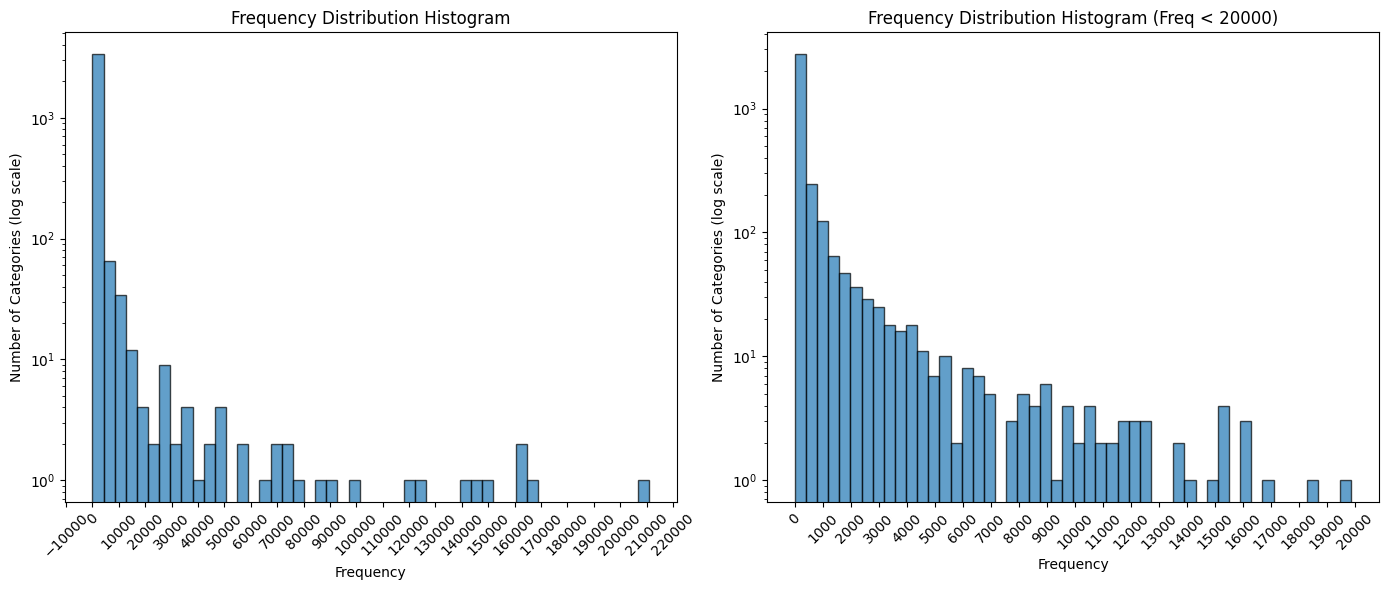

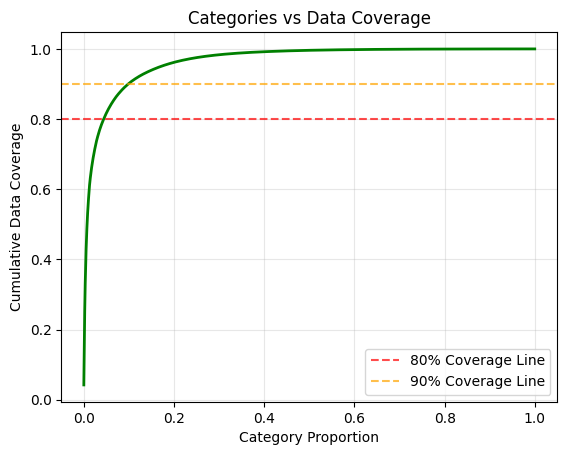

In [ ]:
visualize_long_tail_distribution(scope_frequency,'./scope_analysis/scope_2',is_save=False)

In [ ]:
def analyze_effective_scope_learning(scope_frequency, model, test_dataloader,id_to_scopes,ignore_label_id=-100,):
    """分析模型能否有效學習不同頻率的範疇"""
    print(f"\n=== 分析模型對不同頻率範疇的學習效果 ===")
    device = next(model.parameters()).device 
    # 按頻率將範疇分組
    
    median = int(np.median(list(scope_frequency.values())))
    high_freq_scopes = {scope for scope, freq in scope_frequency.items() if freq >= 10000}
    mid_freq_scopes = {scope for scope, freq in scope_frequency.items() if median <= freq < 10000}
    low_freq_scopes = {scope for scope, freq in scope_frequency.items() if freq < median}
    
    print(f"高頻範疇 (≥10000): {len(high_freq_scopes)}個")
    print(f"中頻範疇 ({median}-9999): {len(mid_freq_scopes)}個") 
    print(f"低頻範疇 (<{median}): {len(low_freq_scopes)}個")
    
    # 測試模型在不同頻率範疇上的表現
    model.eval()
    performance_by_freq = {
        'high_freq': {'correct': 0, 'total': 0, 'confidence_sum': 0},
        'mid_freq': {'correct': 0, 'total': 0, 'confidence_sum': 0},
        'low_freq': {'correct': 0, 'total': 0, 'confidence_sum': 0}
    }

    test_scope_frequency = Counter()
    
    with torch.no_grad():
        for batch in test_dataloader:
            batch = batch.to(device)
            
            # 獲取模型輸出
            model_out = model(
                batch.question_ebds, batch.q_atten_masks, batch.q_span_tables,
                batch.positive_ebds, batch.positive_atten_masks, batch.positive_span_tables,
                batch.negative_ebds, batch.negative_atten_masks, batch.negative_span_tables
            )
            if hasattr(model_out, 'q_scope_logits'):
                    
                q_probs = torch.softmax(model_out.q_scope_logits, dim=-1)
                q_preds = q_probs.argmax(dim=-1)
                q_max_probs = q_probs.max(dim=-1)[0]
                q_labels = batch.q_scope_labels
                
                # 分析正樣本範疇預測
                pos_probs = torch.softmax(model_out.positive_scope_logits, dim=-1)
                pos_preds = pos_probs.argmax(dim=-1)
                pos_max_probs = pos_probs.max(dim=-1)[0]
                pos_labels = batch.positive_scope_labels
                

                
                # 處理問題範疇
                for i in range(q_labels.size(0)):
                    for j in range(q_labels.size(1)):
                        if q_labels[i, j] != ignore_label_id:
                            true_scope = q_labels[i, j].item()
                            true_scope_name = id_to_scopes.get(true_scope)
                            test_scope_frequency[true_scope_name] += 1
                            pred_scope = q_preds[i, j].item()
                            confidence = q_max_probs[i, j].item()
                            
                            # 確定範疇頻率類別
                            if true_scope_name in high_freq_scopes:
                                freq_category = 'high_freq'
                            elif true_scope_name in mid_freq_scopes:
                                freq_category = 'mid_freq'
                            else:
                                freq_category = 'low_freq'
                            
                            # 更新統計
                            performance_by_freq[freq_category]['total'] += 1
                            performance_by_freq[freq_category]['confidence_sum'] += confidence
                            if true_scope == pred_scope:
                                performance_by_freq[freq_category]['correct'] += 1
                
                # 處理正樣本範疇
                for i in range(pos_labels.size(0)):
                    for j in range(pos_labels.size(1)):
                        if pos_labels[i, j] != ignore_label_id:
                            true_scope = pos_labels[i, j].item()
                            true_scope_name = id_to_scopes.get(true_scope)
                            test_scope_frequency[true_scope_name] += 1
                            pred_scope = pos_preds[i, j].item()
                            confidence = pos_max_probs[i, j].item()
                            
                            # 確定範疇頻率類別
                            if true_scope_name in high_freq_scopes:
                                freq_category = 'high_freq'
                            elif true_scope_name in mid_freq_scopes:
                                freq_category = 'mid_freq'
                            else:
                                freq_category = 'low_freq'
                            
                            # 更新統計
                            performance_by_freq[freq_category]['total'] += 1
                            performance_by_freq[freq_category]['confidence_sum'] += confidence
                            if true_scope == pred_scope:
                                performance_by_freq[freq_category]['correct'] += 1
    
    train_scopes = set(list(scope_frequency.keys()))
    test_scopes = set(list(test_scope_frequency.keys()))
    overlap = set(train_scopes).intersection(test_scopes)
    
    print(f'Overlap nums: {len(overlap)}')
    print(f'Testing set scope overlap: {len(overlap) / len(train_scopes):.3f}%')
    # 打印結果
    for freq_type, stats in performance_by_freq.items():
        if stats['total'] > 0:
            accuracy = stats['correct'] / stats['total']
            avg_confidence = stats['confidence_sum'] / stats['total']
            print(f"{freq_type}: 準確率={accuracy:.4f}, 平均置信度={avg_confidence:.4f}, 樣本數={stats['total']}")
    
    return performance_by_freq

In [8]:
print("=== 比較 1429 vs 17872 範疇設置 ===")
config_path = Path(os.getcwd()).joinpath('configs/Config.yaml')
with open(config_path,'r') as f:
    configs = yaml.safe_load(f)

granularity = configs['data'].get('granularity')
train_type = configs['strategy'].get('train_type')
pooling_method = configs['strategy'].get('pooling_method')
with_negative_sample = configs['data'].get('with_negative_sample')
seg_type = configs['data']['seg_type']
batch_size = configs['hyperparam']['batch_size']
temp = configs['hyperparam']['temp']

print(f'granularity: {granularity} | \
        with_negative_sample: {with_negative_sample} | \
        train_type: {train_type} |\
        pooling_method: {pooling_method}')


names = Store_name(with_negative_sample,train_type,pooling_method,granularity,configs['store'])




collate_fn = Collate_fn(padding_label=-100)

data_root_path = Path(os.getcwd()).joinpath('data/QA/Tiny')

train_dataset = QA_Pairs_Dataset(
                data_root_path=data_root_path,
                seg_type=seg_type,
                dataset_type='train',
                granularity=granularity
                )

test_dataset = QA_Pairs_Dataset(
                data_root_path=data_root_path,
                seg_type=seg_type,
                dataset_type='test',
                granularity=granularity
                )
id_to_scopes = {v:k for k,v in train_dataset.scope_to_ids.items() }

# test_dataset = QA_Pairs_Dataset(
#                 data_root_path=data_root_path,
#                 seg_type=seg_type,
#                 dataset_type='test',
#                 granularity=granularity
#                 )

train_dataloader = DataLoader(train_dataset,collate_fn=collate_fn,batch_size=batch_size,shuffle=False)
test_dataloader = DataLoader(test_dataset,collate_fn=collate_fn,batch_size=batch_size,shuffle=False)
# test_dataloder = DataLoader(test_dataset,collate_fn=collate_fn,batch_size=batch_size,shuffle=False)


device = 'cuda' if torch.cuda.is_available() else 'cpu'
num_scopes = len(train_dataset.scope_to_ids) - 1 # 扣除 <unk> label

model_path = Path(names.get('model_save_path'),'best_checkpoint.pt')
print(model_path)
model = ScopeEnhancedDualEncoder(
                                configs['encoder'],
                                num_scopes = num_scopes,
                                train_type=train_type,
                                pooling_method=pooling_method
                                )


model.load_state_dict(torch.load(model_path,weights_only=True))
model = model.to('cuda')


=== 比較 1429 vs 17872 範疇設置 ===
granularity: 3 |         with_negative_sample: True |         train_type: scope_enhanced |        pooling_method: cls
/home/corngun/RAG/main/checkpoint/dual-encoder/with_hard_neg/granularity_3_cls_all_negs/best_checkpoint.pt


### 第三層範疇

In [9]:
analyzer = LongTailCategoryAnalyzer(num_scopes,id_to_scopes)

In [10]:
analyzer.analyze_dataset_coverage(train_dataloader, "訓練集")


=== 分析 訓練集 數據集的範疇分布 ===
總樣本數: 72000
總範疇標籤數: 2497119
理論範疇總數: 1429
實際出現的範疇數: 1373
範疇覆蓋率: 0.9608
未出現的範疇數: 56


In [11]:
_calculate_coverage_statistics(analyzer.scope_frequency)

{'total_scopes_appeared': 1373,
 'total_occurrences': 2497119,
 'mean_frequency': np.float64(1818.7319737800437),
 'median_frequency': np.float64(167.0),
 'std_frequency': np.float64(7323.865394224645),
 'min_frequency': 1,
 'max_frequency': 151094,
 'scopes_freq_ge_100': 804,
 'scopes_freq_ge_100_ratio': 0.58557902403496,
 'scopes_freq_ge_1000': 338,
 'scopes_freq_ge_1000_ratio': 0.24617625637290605,
 'scopes_freq_ge_10000': 56,
 'scopes_freq_ge_10000_ratio': 0.04078659868900218,
 'top_1percent_scopes_coverage': (np.float64(0.32145083994795604), 13),
 'top_5percent_scopes_coverage': (np.float64(0.6251788561137855), 68),
 'top_10percent_scopes_coverage': (np.float64(0.771626021827554), 137),
 'top_20percent_scopes_coverage': (np.float64(0.8940551091077358), 274),
 'top_50percent_scopes_coverage': (np.float64(0.9865865423313827), 686)}

In [12]:
sorted_items = sorted(analyzer.scope_frequency.items(), key=lambda x: x[1], reverse=True)
sorted_items[:10]

[('_Kd01', 151094),
 ('_Dk06', 84257),
 ('Punc_1', 83685),
 ('Punc_2', 80336),
 ('Punc_3', 72466),
 ('_Kc01', 63095),
 ('_Ka35', 54117),
 ('_Kb01', 43663),
 ('_Ae13', 42264),
 ('_Hj28', 34824)]

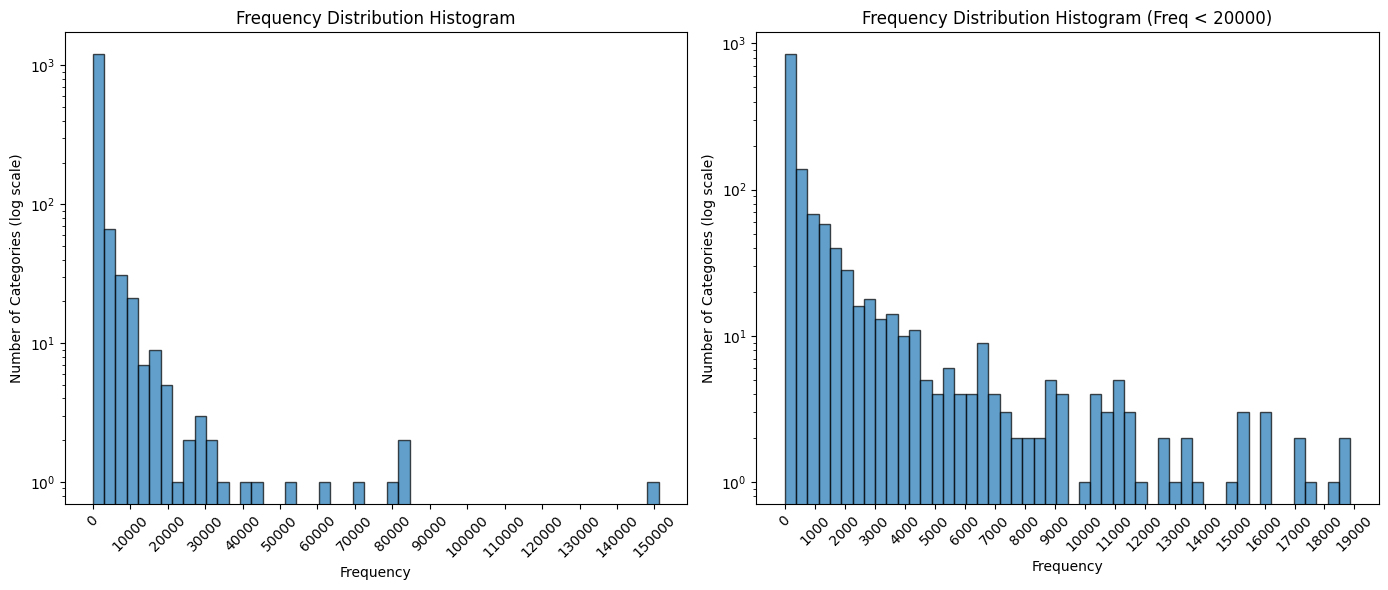

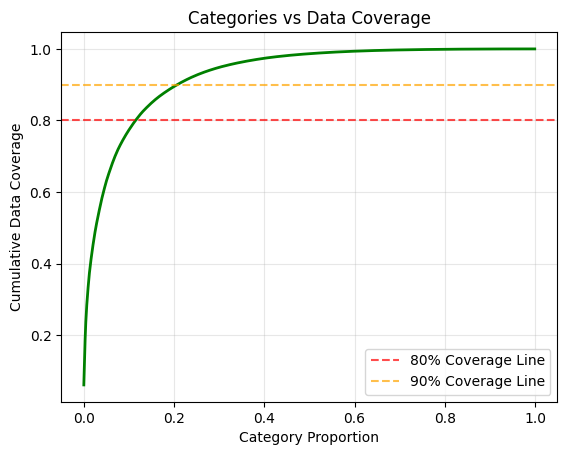

In [14]:
visualize_long_tail_distribution(analyzer.scope_frequency,'./scope_analysis/scope_3',is_save=True)

In [13]:
learning_performance = analyze_effective_scope_learning(analyzer.scope_frequency,model, test_dataloader,id_to_scopes)


=== 分析模型對不同頻率範疇的學習效果 ===
高頻範疇 (≥10000): 56個
中頻範疇 (167-9999): 631個
低頻範疇 (<167): 686個
Overlap nums: 1251
Testing set scope overlap: 0.911%
high_freq: 準確率=0.9270, 平均置信度=0.9107, 樣本數=203650
mid_freq: 準確率=0.8096, 平均置信度=0.7804, 樣本數=140668
low_freq: 準確率=0.4793, 平均置信度=0.4219, 樣本數=4598


### 第五層範疇

In [7]:
analyzer = LongTailCategoryAnalyzer(num_scopes,id_to_scopes)

In [8]:
analyzer.analyze_dataset_coverage(train_dataloader, "訓練集")


=== 分析 訓練集 數據集的範疇分布 ===
總樣本數: 72000
總範疇標籤數: 2497119
理論範疇總數: 17872
實際出現的範疇數: 8759
範疇覆蓋率: 0.4901
未出現的範疇數: 9113


In [9]:
sorted_items = sorted(analyzer.scope_frequency.items(), key=lambda x: x[1], reverse=True)
sorted_items[10:20]

[('_Dk06C02', 25595),
 ('_Hj28A01', 25278),
 ('_Hg08A01', 24756),
 ('_Ae13B01', 18482),
 ('_Dk06C01', 17311),
 ('_Gb08A01', 15598),
 ('_Ed61A01', 15417),
 ('_Ba10B01', 15208),
 ('_Ed01C01', 15133),
 ('_Hg14C01', 14452)]

In [10]:
_calculate_coverage_statistics(analyzer.scope_frequency)

{'total_scopes_appeared': 8759,
 'total_occurrences': 2497119,
 'mean_frequency': np.float64(285.09179130037677),
 'median_frequency': np.float64(9.0),
 'std_frequency': np.float64(2612.7899262646038),
 'min_frequency': 1,
 'max_frequency': 146898,
 'scopes_freq_ge_100': 1676,
 'scopes_freq_ge_100_ratio': 0.19134604406895764,
 'scopes_freq_ge_1000': 406,
 'scopes_freq_ge_1000_ratio': 0.04635232332458043,
 'scopes_freq_ge_10000': 31,
 'scopes_freq_ge_10000_ratio': 0.003539216805571412,
 'top_1percent_scopes_coverage': (np.float64(0.5282579644782648), 87),
 'top_5percent_scopes_coverage': (np.float64(0.7977425184782944), 437),
 'top_10percent_scopes_coverage': (np.float64(0.8966629143424882), 875),
 'top_20percent_scopes_coverage': (np.float64(0.9603150670833068), 1751),
 'top_50percent_scopes_coverage': (np.float64(0.994283812665716), 4379)}

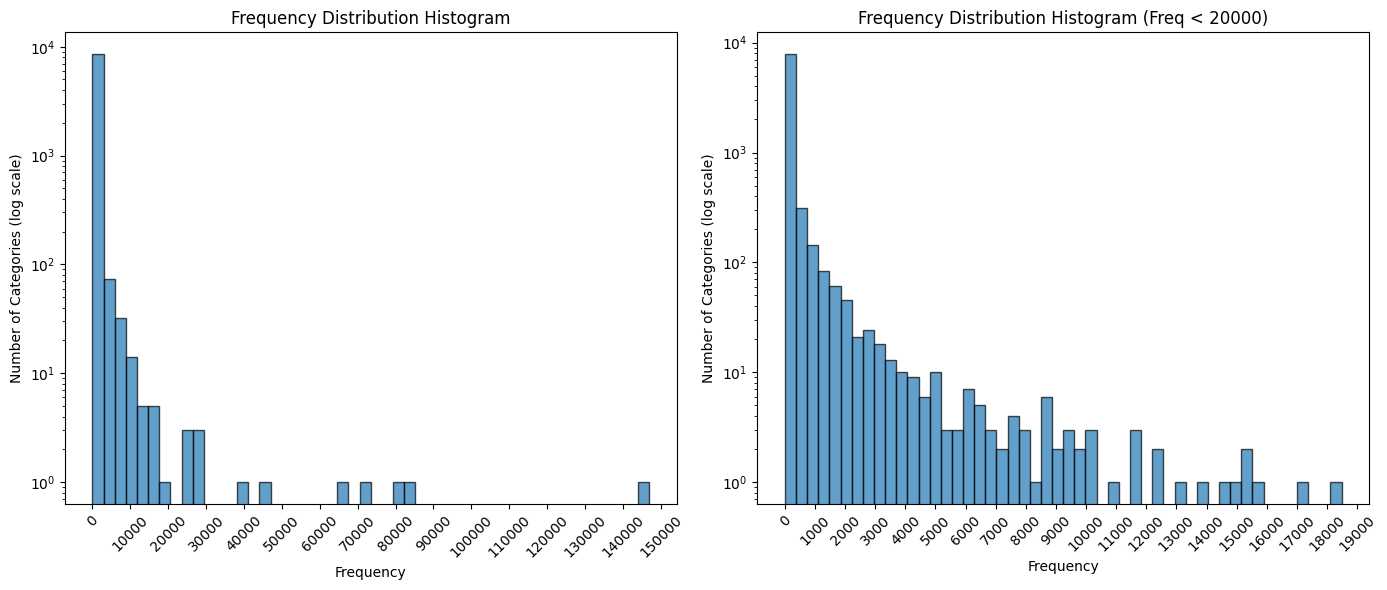

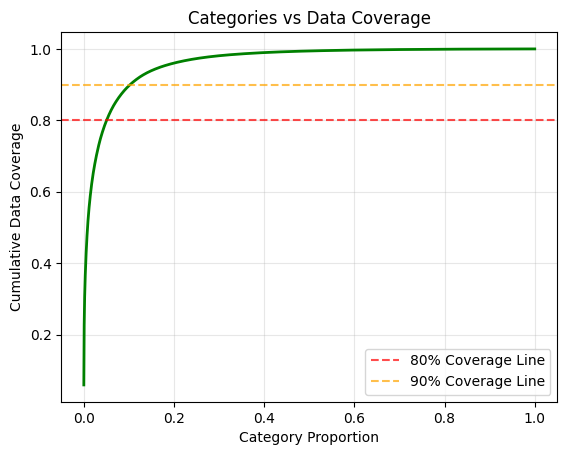

In [18]:
visualize_long_tail_distribution(analyzer.scope_frequency,'./scope_analysis/scope_5',is_save=True)

In [15]:
learning_performance = analyze_effective_scope_learning(analyzer.scope_frequency,model, test_dataloader,id_to_scopes)


=== 分析模型對不同頻率範疇的學習效果 ===
高頻範疇 (≥10000): 31個
中頻範疇 (9-9999): 4516個
低頻範疇 (<9): 4212個
Overlap nums: 5125
Testing set scope overlap: 0.585%
high_freq: 準確率=0.9588, 平均置信度=0.9338, 樣本數=130618
mid_freq: 準確率=0.8311, 平均置信度=0.7475, 樣本數=216317
low_freq: 準確率=0.0071, 平均置信度=0.1166, 樣本數=1981
